In [3]:
#pip install xgboost

  Obtaining dependency information for xgboost from https://files.pythonhosted.org/packages/45/6d/8c1d2570a52db6263d855c3ee3daf8f4bdf4a365cd6610772d6fce5fd904/xgboost-2.0.3-py3-none-macosx_10_15_x86_64.macosx_11_0_x86_64.macosx_12_0_x86_64.whl.metadata
   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.2/2.2 MB 12.0 MB/s eta 0:00:0000:0100:01
Note: you may need to restart the kernel to use updated packages.


In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
from sklearn.cluster import KMeans
from sklearn.mixture import GaussianMixture
from scipy.cluster.hierarchy import dendrogram, linkage
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from xgboost import XGBRegressor
from sklearn.metrics import mean_squared_error
import matplotlib.pyplot as plt

# Import Datasets

In [3]:
college_data = pd.read_csv("college_data.csv")
education_data = pd.read_csv("Education.csv")

/var/folders/kx/cymfml1j1xzdk5_lrrb1fnqh0000gn/T/ipykernel_22943/731911853.py:1: DtypeWarning: Columns (10,11,12) have mixed types. Specify dtype option on import or set low_memory=False.
  college_data = pd.read_csv("college_data.csv")


# Cleaning Data

## Part 1: education_data

In [4]:
# Split 'cd' column into 'State' and 'District' columns
education_data[['District', 'State']] = education_data['cd'].str.split('_', expand=True)

# Group by 'Year', 'State', and 'District' and sum the values
grouped_education_data = education_data.groupby(['Year', 'State']).sum()

# Reset index to make 'Year' and 'State' as columns
grouped_education_data.reset_index(inplace=True)

# Reorder the columns
grouped_education_data = grouped_education_data[['Year', 'State', 'Bachelors_degree_or_higher', 'high_school_or_some_degree', 'Less_than_high_school_graduate']]

#grouped_education_data

In [5]:
column_rename_map = {
    'Year': 'Year',
    'State': 'State',
    'Bachelors_degree_or_higher': 'Bachelors or Higher',
    'high_school_or_some_degree': 'High School Graduate',
    'Less_than_high_school_graduate': 'Did Not Graduate High School'
}

education_final = grouped_education_data.rename(columns=column_rename_map)
education_final

,Year,State,Bachelors or Higher,High School Graduate,Did Not Graduate High School
0,2020,AK,121098,309698,33572
1,2020,AL,727011,1914775,359092
2,2020,AR,401604,1192299,207823
3,2020,AZ,1149452,2584647,542240
4,2020,CA,7875797,13288743,3583879
...,...,...,...,...,...
99,2021,VT,145677,227099,24841
100,2021,WA,1636266,2683258,412868
101,2021,WI,1076708,2246152,258266
102,2021,WV,225564,737983,111946


## Part 2: college_data

In [6]:
cols_to_drop = ['CITY','ZIP','LOCALE','LATITUDE','LONGITUDE','CCBASIC','CCUGPROF','CCSIZSET','COSTT4_A',
                'MN_EARN_WNE_INDEP0_P10','MN_EARN_WNE_INDEP1_P10','UGDS_WHITE','UGDS_BLACK','UGDS_HISP',
                'UGDS_ASIAN','UGDS_AIAN','UGDS_NHPI','UGDS_2MOR','UGDS_NRA','UGDS_UNKN']

college_data_cleaned = college_data.drop(columns=cols_to_drop)
college_data_cleaned.dropna(inplace=True)
#college_data_cleaned

In [7]:
column_rename_map = {
    'UNITID': 'ID',
    'INSTNM': 'Name',
    'STABBR': 'State',
    'REGION': 'Region',
    'PREDDEG': 'Predominant Degree',
    'ADM_RATE_ALL': 'Admission Rate',
    'PPTUG_EF': 'Percent Part-Time',
    'SAT_AVG_ALL': 'Average SAT Score',
    'CONTROL': 'Control',
    'TUITIONFEE_IN': 'In State Tuition',
    'TUITIONFEE_OUT': 'Out of State Tuition',
    'MEDIAN_HH_INC': 'Median Household Income',
    'year': 'Year',
}

colleges_final = college_data_cleaned.rename(columns=column_rename_map)
#colleges_final

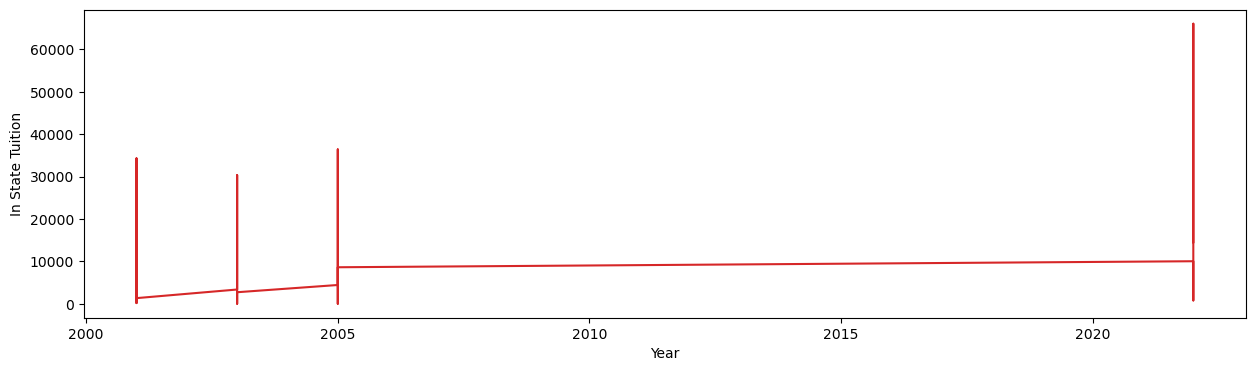

In [8]:
def plot_df(df, x, y, title="", xlabel='Year', ylabel='In State Tuition', dpi=100):
    plt.figure(figsize=(15,4), dpi=dpi)
    plt.plot(x, y, color='tab:red')
    plt.gca().set(title=title, xlabel=xlabel, ylabel=ylabel)
    plt.show()
    

plot_df(colleges_final, x=colleges_final['Year'], y=colleges_final['In State Tuition'], title='')

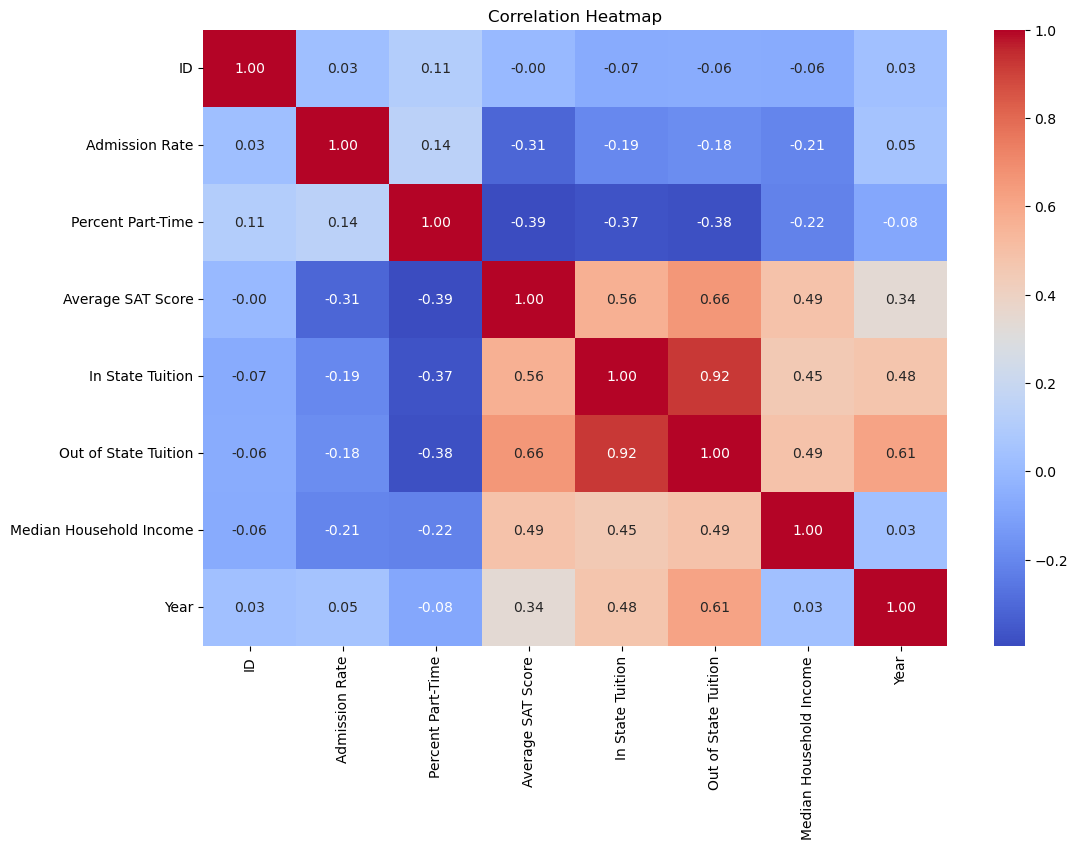

In [9]:
numeric_data = colleges_final.select_dtypes(include=['float64', 'int64'])

# Calculate the correlation matrix
correlation_matrix = numeric_data.corr()

# Create a heatmap
plt.figure(figsize=(12, 8))
sns.heatmap(correlation_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap')
plt.show()

In [10]:
numeric_data.to_csv('numeric_data.csv', index=False)

In [11]:
# Select features: 'Average SAT Score', 'Median Household Income', and 'Year'
X = numeric_data[['Average SAT Score', 'Median Household Income', 'Year']]

# Normalize the features
X_normalized = (X - X.mean()) / X.std()

# Initialize KMeans with the number of clusters
n_clusters = 50  # You can adjust this number based on your dataset
kmeans = KMeans(n_clusters=n_clusters, random_state=42)

# Fit KMeans to the data
kmeans.fit(X_normalized)

# Predict the cluster labels
cluster_labels = kmeans.predict(X_normalized)

# Assign the cluster labels to the dataset
numeric_data['Cluster'] = cluster_labels

# Calculate the average in-state tuition rates for each cluster
average_tuition_by_cluster = numeric_data.groupby('Cluster')['In State Tuition'].mean()

# Predict the likely in-state tuition rates for each data point
predicted_tuition = []
for index, row in numeric_data.iterrows():
    predicted_tuition.append(average_tuition_by_cluster[row['Cluster']])

# Add the predicted in-state tuition rates to the dataset
numeric_data['Predicted In State Tuition'] = predicted_tuition

/Users/grace/anaconda3/lib/python3.11/site-packages/sklearn/cluster/_kmeans.py:1412: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  super()._check_params_vs_input(X, default_n_init=10)


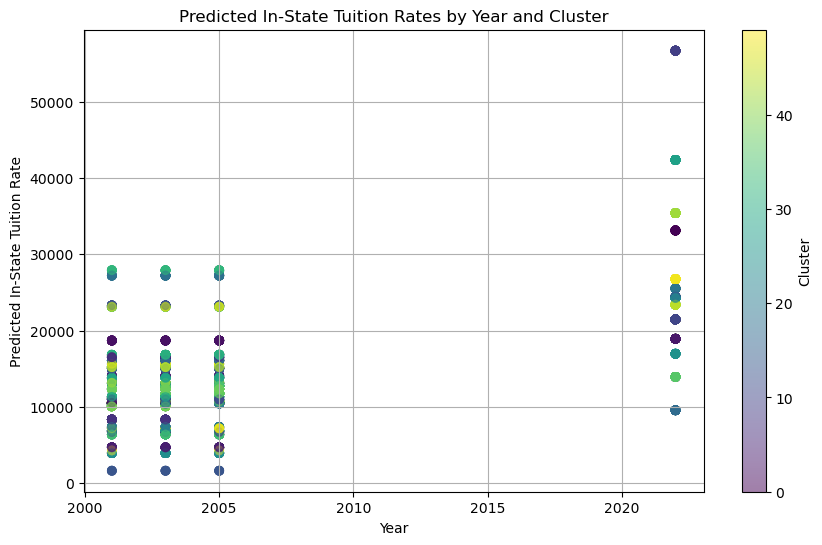

In [12]:
plt.figure(figsize=(10, 6))
plt.scatter(numeric_data['Year'], numeric_data['Predicted In State Tuition'], c=numeric_data['Cluster'], cmap='viridis', alpha=0.5)
plt.colorbar(label='Cluster')
plt.xlabel('Year')
plt.ylabel('Predicted In-State Tuition Rate')
plt.title('Predicted In-State Tuition Rates by Year and Cluster')
plt.grid(True)
plt.show()

In [13]:
features = ['Average SAT Score', 'Median Household Income', 'Year']

# Fit Gaussian Mixture Model
gmm = GaussianMixture(n_components=5, random_state=42)  # Adjust n_components as needed
gmm.fit(numeric_data[features])

# Predict the cluster labels
cluster_labels = gmm.predict(numeric_data[features])

# Add cluster labels to the dataset
numeric_data['Cluster'] = cluster_labels

# Calculate the average in-state tuition rate for each cluster
cluster_tuition = numeric_data.groupby('Cluster')['In State Tuition'].mean()

# Predict the likely in-state tuition rate based on the cluster
def predict_tuition(row):
    return cluster_tuition[row['Cluster']]

# Apply the prediction function to the dataset
numeric_data['Predicted In State Tuition'] = numeric_data.apply(predict_tuition, axis=1)

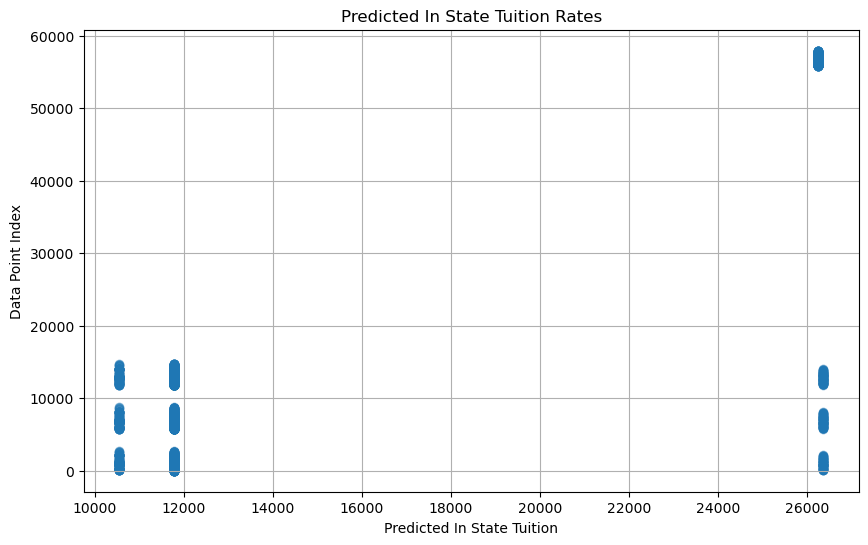

In [14]:
plt.figure(figsize=(10, 6))
plt.scatter(numeric_data['Predicted In State Tuition'], numeric_data.index, alpha=0.5)
plt.xlabel('Predicted In State Tuition')
plt.ylabel('Data Point Index')
plt.title('Predicted In State Tuition Rates')
plt.grid(True)
plt.show()

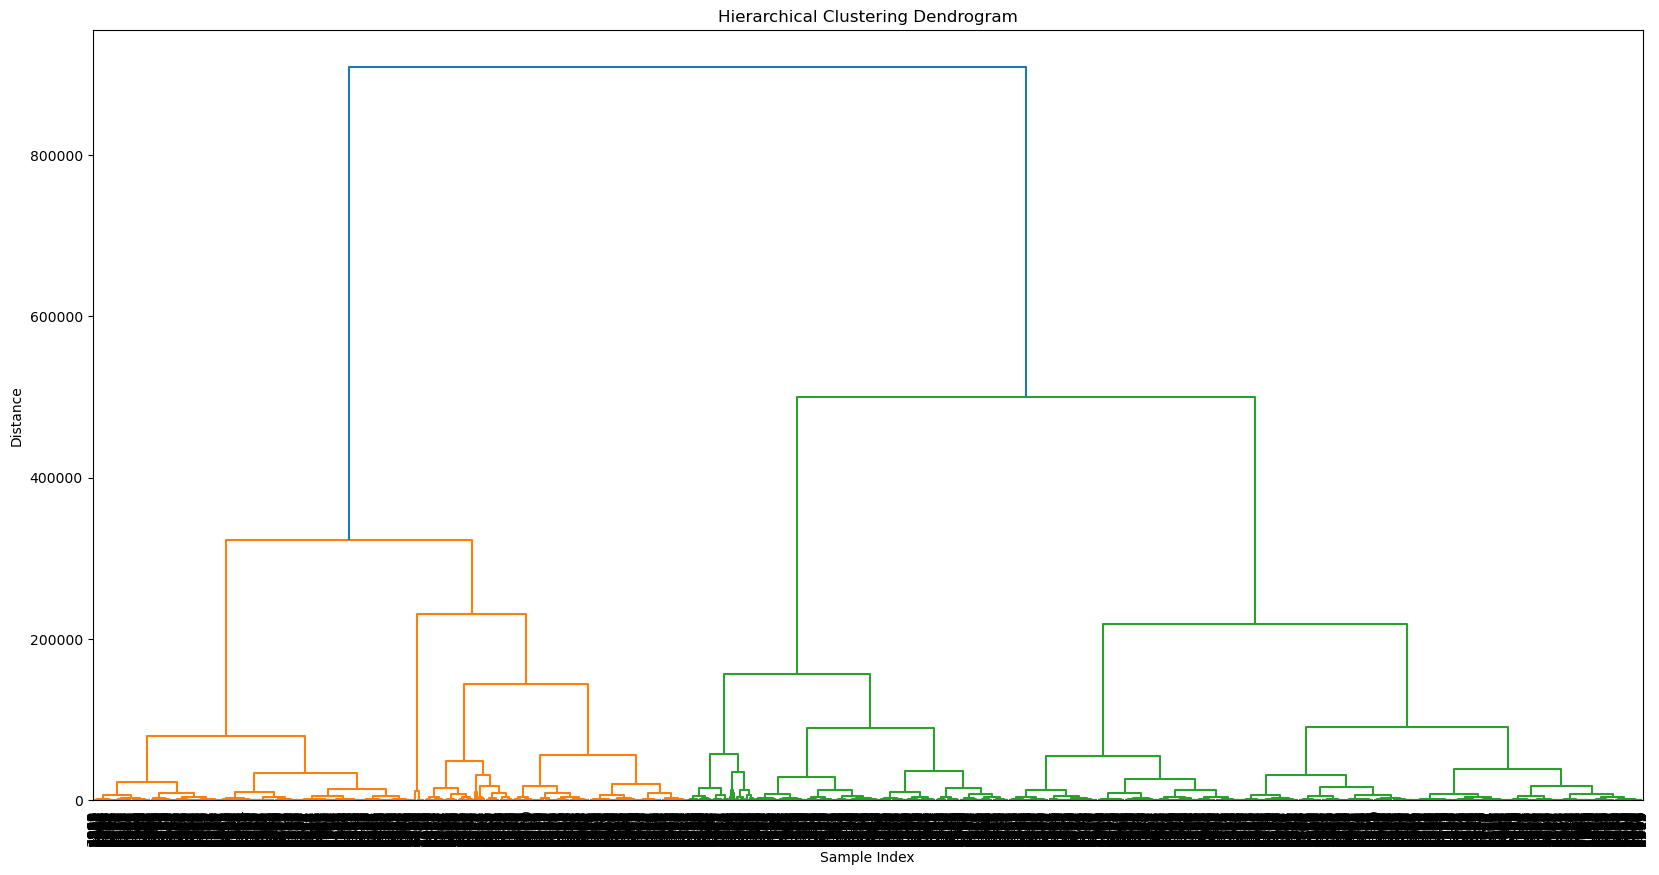

In [15]:
X = numeric_data[['Average SAT Score', 'Median Household Income', 'Year']].values

# Perform hierarchical clustering
Z = linkage(X, method='ward')

# Plot dendrogram
plt.figure(figsize=(20, 10))  # Adjust the figure size as needed
plt.title('Hierarchical Clustering Dendrogram')
plt.xlabel('Sample Index')
plt.ylabel('Distance')
dendrogram(
    Z,
    leaf_rotation=90.,  # rotates the x axis labels
    leaf_font_size=10.,  # font size for the x axis labels
)
plt.show()

In [16]:
X = numeric_data[['Average SAT Score', 'Median Household Income', 'Year']]

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Apply DBSCAN
dbscan = DBSCAN(eps=0.5, min_samples=5)
clusters = dbscan.fit_predict(X_scaled)

# Add the clusters to the dataset
numeric_data['Cluster'] = clusters

# Group by clusters and calculate the mean in-state tuition for each cluster
cluster_means = numeric_data.groupby('Cluster')['In State Tuition'].mean()

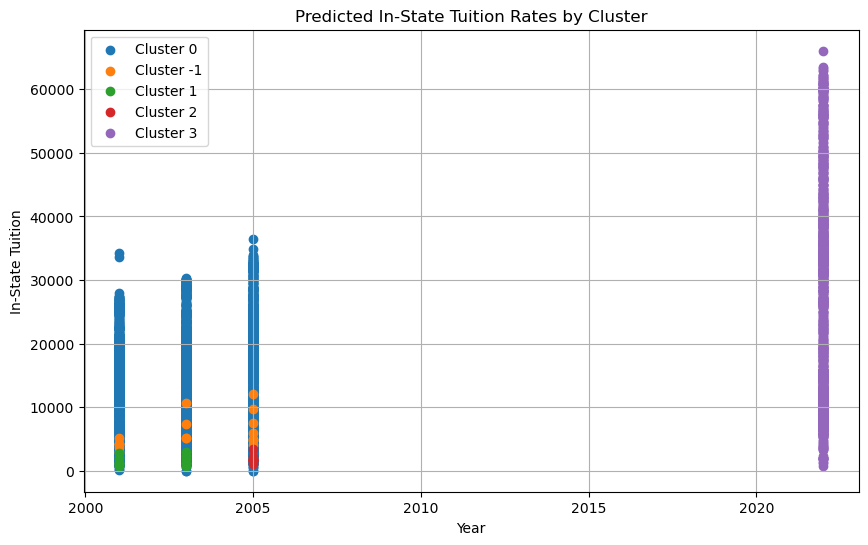

In [17]:
plt.figure(figsize=(10, 6))
for cluster in numeric_data['Cluster'].unique():
    cluster_data = numeric_data[numeric_data['Cluster'] == cluster]
    plt.scatter(cluster_data['Year'], cluster_data['In State Tuition'], label=f'Cluster {cluster}')

plt.title('Predicted In-State Tuition Rates by Cluster')
plt.xlabel('Year')
plt.ylabel('In-State Tuition')
plt.legend()
plt.grid(True)
plt.show()

In [18]:
X = numeric_data[['Average SAT Score', 'Median Household Income', 'Year']]
y = numeric_data['In State Tuition']

# Split the data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

# Train XGBoost model
model = XGBRegressor()
model.fit(X_train, y_train)

# Make predictions
y_pred_train = model.predict(X_train)
y_pred_test = model.predict(X_test)

# Evaluate model
mse_train = mean_squared_error(y_train, y_pred_train)
mse_test = mean_squared_error(y_test, y_pred_test)

print("Mean Squared Error (Train):", mse_train)
print("Mean Squared Error (Test):", mse_test)

Mean Squared Error (Train): 21268924.016927317
Mean Squared Error (Test): 70860595.26861645


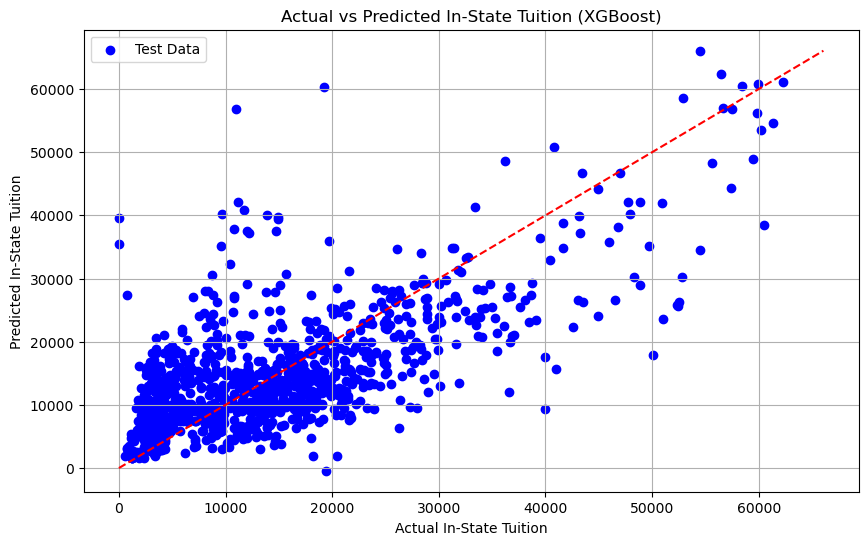

In [19]:
plt.figure(figsize=(10, 6))
plt.scatter(y_test, y_pred_test, color='blue', label='Test Data')
plt.plot([y.min(), y.max()], [y.min(), y.max()], color='red', linestyle='--')
plt.xlabel('Actual In-State Tuition')
plt.ylabel('Predicted In-State Tuition')
plt.title('Actual vs Predicted In-State Tuition (XGBoost)')
plt.legend()
plt.grid(True)
plt.show()

# Merge the datasets

In [19]:
merged_dataset = pd.merge(colleges_final, education_final, on=['State', 'Year'])

In [20]:
merged_dataset.head()

,ID,Name,State,Region,Predominant Degree,Admission Rate,Percent Part-Time,Average SAT Score,Control,In State Tuition,Out of State Tuition,Median Household Income,Year,Bachelors or Higher,High School Graduate,Did Not Graduate High School
